In [2]:
import os
os.chdir("") # set directory according to the github folder 

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy
import statsmodels
import pymc as pm
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)

2023-05-05 16:14:31.889044: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
df = pd.read_csv("cookiecats.csv")

# Explanatory Data Analysis & Data Manipulation

The data we have is from 90,189 players that installed the game after the AB-test started to run. The variables of `df` are:
<ul>
<li><code>df.version</code> - whether the player was put in the control <b>group A</b> (<code>gate_30</code> - gate set at level 30) or in control <b>group B</b> (<code>gate_40</code> - gate set at level 40)
<li><code>df.sum_gamerounds</code> - the number of game rounds played by the player during the <b>first 14 days</b> after install.</li>
<li><code>df.retention_1</code> - whether the player came back and play <strong>1 day</strong> after installing the game</li>
<li><code>df.retention_7</code> - whether the player came back and play <strong>7 days</strong> after installing the game</li>
</ul>
<p>Therefore a player who installed the game was randomly assigned to either <code>gate_30</code> or <code>gate_40</code>. 

At first glance, here's how our dataset looked like:  

In [ ]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In this first operation, we chose to drop the first column `user_id` as it resulted redundant with respect to the row index. We also chose to set both `retention_1` & `retention_7` to `int`.

In [5]:
df[["retention_1", "retention_7"]] = df[["retention_1", "retention_7"]].astype(int)
df.drop("userid", axis = 1, inplace = True)

In [6]:
log_df = df.drop(df[df['sum_gamerounds'] == 0].index, axis=0)

In [7]:
df.drop(df[df['sum_gamerounds'] == 0].index, axis=0, inplace = True)

Drop the highest value as it resulted as an outlier.

In [8]:
max_idx = df["sum_gamerounds"].idxmax()
df = df.drop(max_idx)

In [9]:
df["sum_gamerounds"].max()

2961

In the following chunk we splitted the `df` in the respective *A* (`df_gate_30`) and *B* (`df_gate_40`) groups of the A/B Test

In [10]:
df_gate_30 = df.loc[df["version"] == "gate_30"]
df_gate_40 = df.loc[df["version"] == "gate_40"]

We check for their lengths. We denote that the participants of the A/B Test were uneven. 

In [11]:
len(df_gate_30), len(df_gate_40) # Almost the same

(42762, 43432)

The _retention rate after 1 day_ for both groups. Note that this is pretty much the result that we would espect if we were to update our beliefs given an *informative prior*.

In [12]:
print(df_gate_30["retention_1"].sum() / len(df_gate_30), df_gate_40["retention_1"].sum() / len(df_gate_40))

0.46754127496375286 0.46217074967765703


The _retention rate after 7 day_ for both groups.

In [13]:
print(df_gate_30["retention_7"].sum() / len(df_gate_30), df_gate_40["retention_7"].sum() / len(df_gate_40))

0.19842383424535803 0.1903205010130779


In [14]:
print(df["sum_gamerounds"].min(), df["sum_gamerounds"].max(), df["sum_gamerounds"].mean())

1 2961 53.698296865211034


In [15]:
sorted_data = np.sort(df["sum_gamerounds"])
yvals = np.arange(len(sorted_data)) / float(len(sorted_data))

p90 = np.percentile(sorted_data, 90)
print("90th percentile of sum_gamerounds:", p90)

90th percentile of sum_gamerounds: 140.0


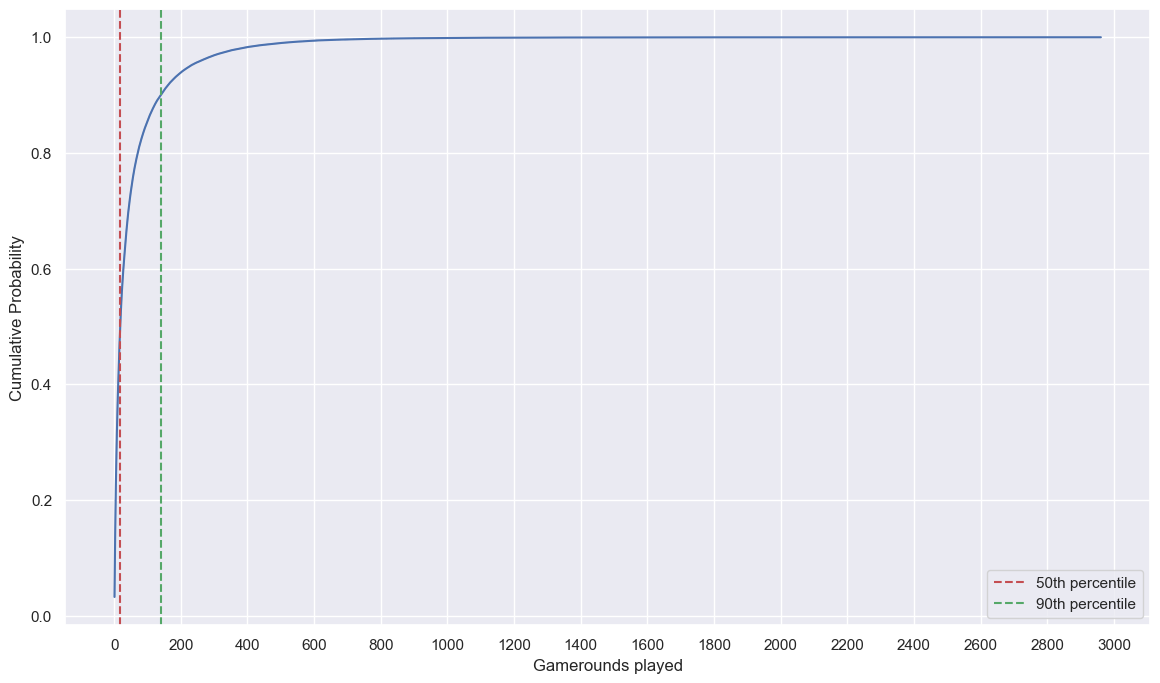

In [16]:
sns.set_style('ticks')
sns.set_theme()
plt.figure(figsize=(14,8))
plt.xticks(range(0,3001,200))

sorted_data = np.sort(df["sum_gamerounds"])
yvals = np.arange(len(sorted_data)) / float(len(sorted_data))

p50 = np.percentile(sorted_data, 50)
p90 = np.percentile(sorted_data, 90)

sns.lineplot(x=sorted_data, y=yvals)
plt.axvline(p50, color='r', linestyle='--', label='50th percentile')
plt.axvline(p90, color='g', linestyle='--', label='90th percentile')

plt.xlabel('Gamerounds played')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()

### Bayesian Logistic Regression - EDA

In [17]:
log_df = log_df[log_df["sum_gamerounds"] < 1000]

In [18]:
rate_list = []

for i in range(0, 1001, 10):
    
    a = len(log_df[log_df["sum_gamerounds"] > i])
    b = log_df[log_df["sum_gamerounds"] > i]["retention_7"].sum()

    c = b / a 

    rate_list.append(c)
    
    c = 0

/var/folders/1z/rcb05c357mq09gbkdvjb882c0000gn/T/ipykernel_13796/1583355857.py:8: RuntimeWarning: invalid value encountered in long_scalars
  c = b / a


Text(0, 0.5, '$r$')

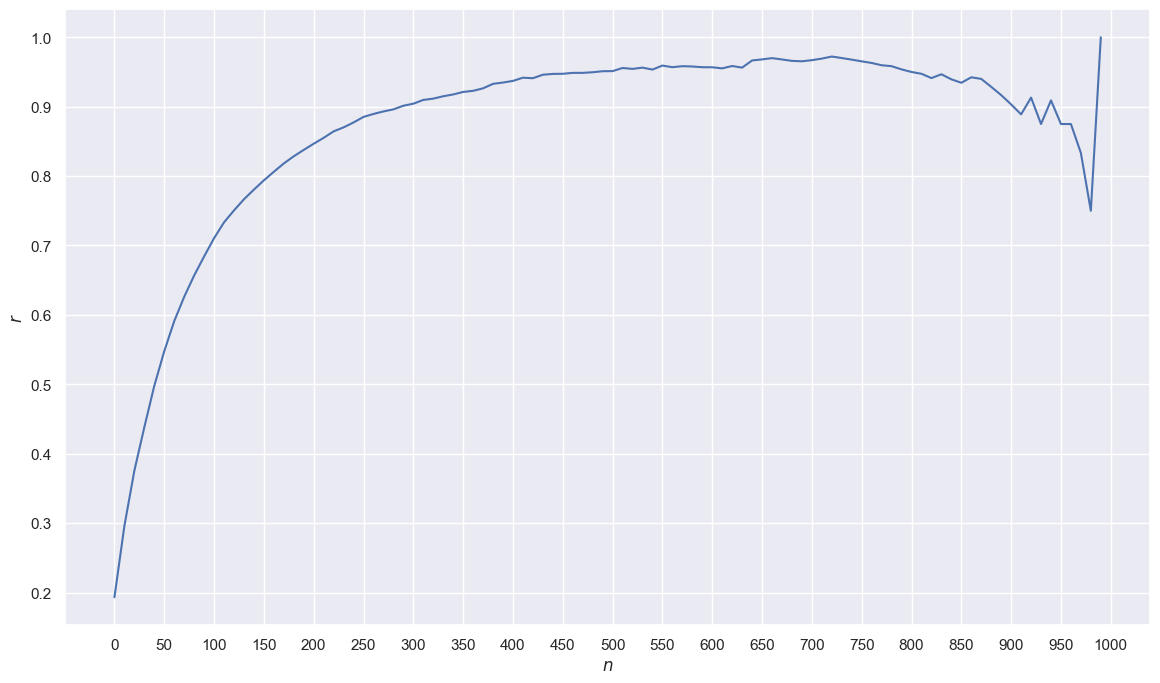

In [19]:
sns.set_style('ticks')
sns.set_theme()
plt.figure(figsize=(14,8))


sns.lineplot(x=list(range(0,1001, 10)), y=rate_list)

plt.xlabel(r'$n$')
plt.xticks(range(0,1001,50))
plt.ylabel(r"$r$")


# A/B TEST

### `retention_1`

In [22]:
with pm.Model() as retention_1:

    # prior
    prior_gate_30 = pm.Beta('prior_gate_30', alpha=1, beta=1)
    prior_gate_40 = pm.Beta('prior_gate_40', alpha=1, beta=1)

    # metrics
    pm.Deterministic('lift', prior_gate_40 - prior_gate_30)
    pm.Deterministic('percent_lift', (prior_gate_40/prior_gate_30) - 1)

    # likelihood 
    lik_gate_30 = pm.Binomial('lik_gate_30', n=len(df_gate_30), p=prior_gate_30, observed=sum(df_gate_30["retention_1"]))
    lik_gate_40 = pm.Binomial('lik_gate_40', n=len(df_gate_40), p=prior_gate_40, observed=sum(df_gate_40["retention_1"]))

    # Gibbs sampling step method
    step = pm.Metropolis(vars=[prior_gate_30, prior_gate_40], proposal_distribution=pm.Categorical)
    # trace
    trace = pm.sample(draws=50000, step = step, progressbar=True, chains = 4)
    burned_trace = trace.sel(draw=slice(10000, None))

Multiprocess sampling (4 chains in 2 jobs)
CompoundStep
>Metropolis: [prior_gate_30]
CompoundStep
>Metropolis: [prior_gate_30]
>Metropolis: [prior_gate_40]


Sampling 4 chains for 1_000 tune and 50_000 draw iterations (4_000 + 200_000 draws total) took 123 seconds.


<Figure size 700x700 with 0 Axes>

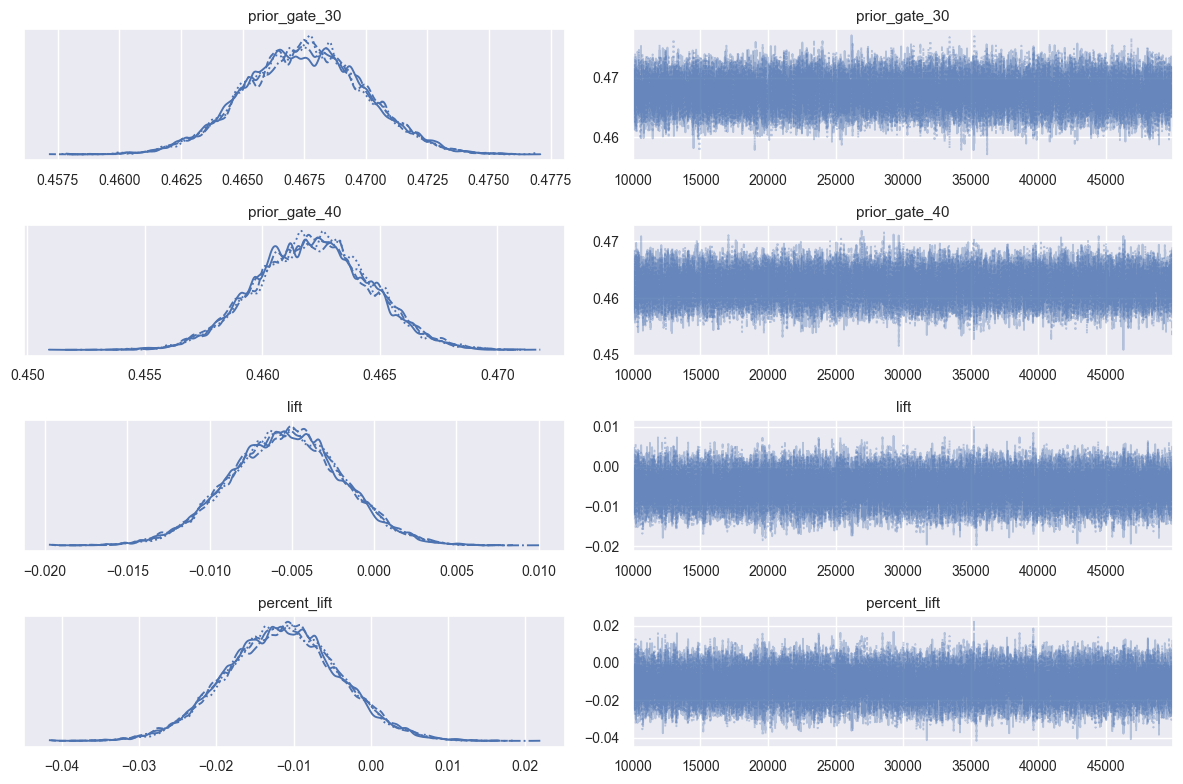

In [23]:
plt.figure(figsize=(7, 7))
az.plot_trace(burned_trace)
plt.tight_layout()

In [24]:
post_gate_30 = burned_trace["posterior"]["prior_gate_30"]
post_gate_40 = burned_trace["posterior"]["prior_gate_40"]
post_lift = burned_trace["posterior"]["lift"]
post_p_lift = burned_trace["posterior"]["percent_lift"]

In [25]:
post_lift.mean()

<xarray.DataArray 'lift' ()>
array(-0.00535031)

/var/folders/1z/rcb05c357mq09gbkdvjb882c0000gn/T/ipykernel_13796/2888069725.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(post_gate_30[1].values, hist=True, kde=True, bins=25, label=r"$\pi(\theta_A^1|\underset{{\_}}{x}_A)$", color="tab:red", kde_kws={'linewidth': 2})
/var/folders/1z/rcb05c357mq09gbkdvjb882c0000gn/T/ipykernel_13796/2888069725.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the 

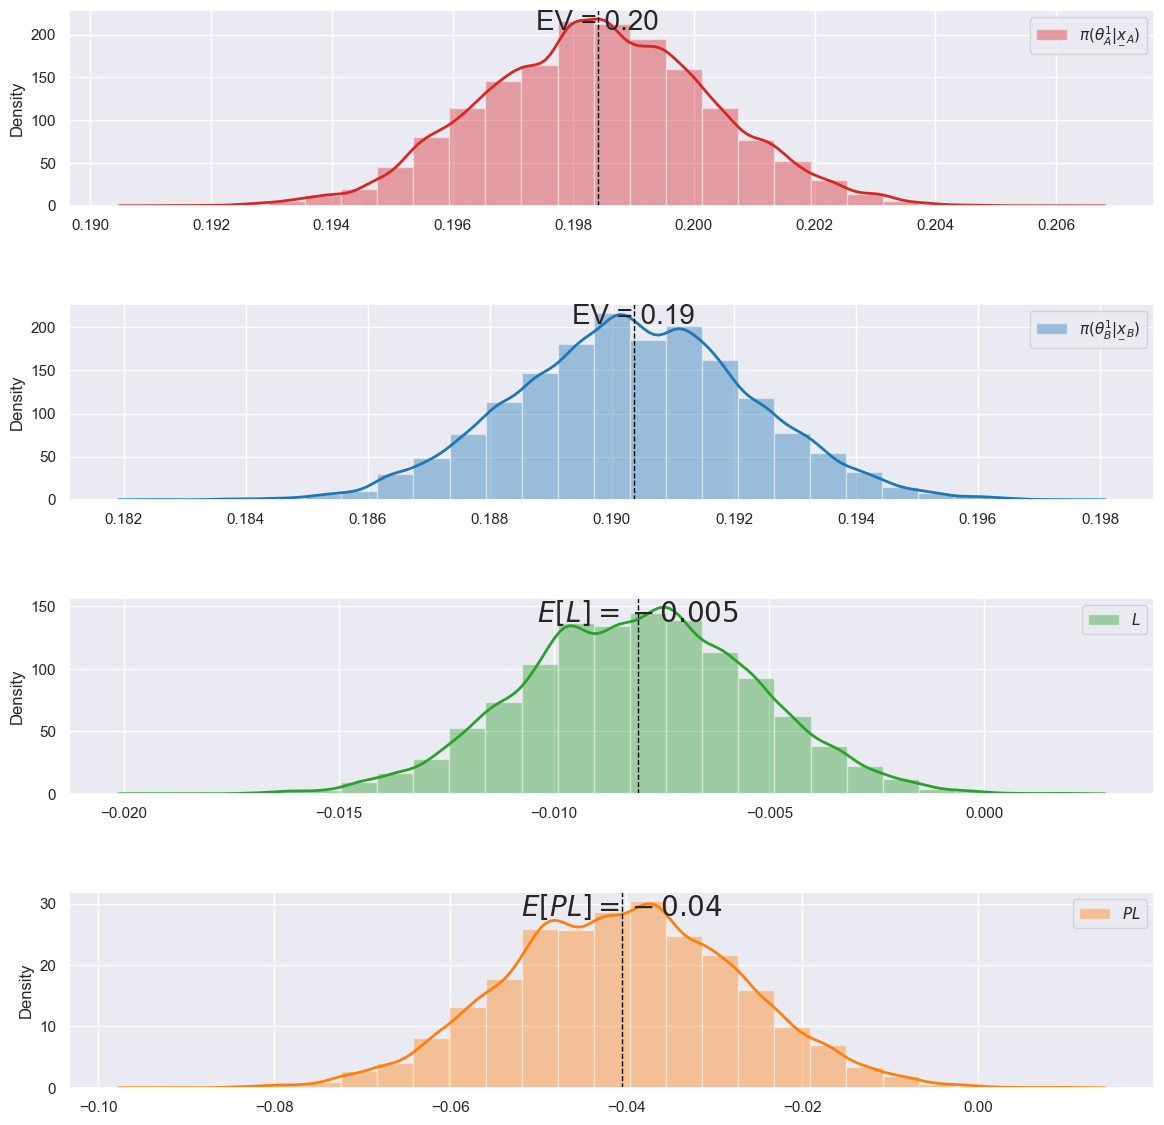

In [38]:
# create a new figure with a larger size
fig = plt.figure(figsize=(14, 14))
sns.set_theme()

# create subplots as before
ax = plt.subplot(411)
plt.subplots_adjust(hspace=0.5)
sns.distplot(post_gate_30[1].values, hist=True, kde=True, bins=25, label=r"$\pi(\theta_A^1|\underset{{\_}}{x}_A)$", color="tab:red", kde_kws={'linewidth': 2})
plt.legend(loc="upper right")

# calculate and add the expected value
mu_30 = np.mean(post_gate_30[1].values)
plt.axvline(mu_30, color='black', linestyle='dashed', linewidth=1)
plt.text(mu_30, plt.ylim()[1],f'EV = {mu_30:.2f}', ha='center', va='top', fontsize=20)

ax = plt.subplot(412)
sns.distplot(post_gate_40[1].values, hist=True, kde=True, bins=25, label=r"$\pi(\theta_B^1|\underset{{\_}}{x}_B)$", color="tab:blue", kde_kws={'linewidth': 2})
plt.legend(loc="upper right")
# calculate and add the expected value
mu_40 = np.mean(post_gate_40[1].values)
plt.axvline(mu_40, color='black', linestyle='dashed', linewidth=1)
plt.text(mu_40, plt.ylim()[1], f'EV = {mu_40:.2f}', ha='center', va='top', fontsize=20)

ax = plt.subplot(413)
sns.distplot(post_lift[1].values, hist=True, kde=True, bins=25, label="$L$", color="tab:green", kde_kws={'linewidth': 2})
plt.legend(loc="upper right")
# calculate and add the expected value
mu_lift = np.mean(post_lift[1].values)
plt.axvline(mu_lift, color='black', linestyle='dashed', linewidth=1)
plt.text(mu_lift, plt.ylim()[1], f'$E[L] = -0.005$', ha='center', va='top', fontsize=20)

ax = plt.subplot(414)
sns.distplot(post_p_lift[1].values, hist=True, kde=True, bins=25, label="$PL$", color="tab:orange", kde_kws={'linewidth': 2})
plt.legend(loc="upper right")
# calculate and add the expected value
mu_p_lift = np.mean(post_p_lift[1].values)
plt.axvline(mu_p_lift, color='black', linestyle='dashed', linewidth=1)
plt.text(mu_p_lift, plt.ylim()[1], f'$E[PL] = {mu_p_lift:.2f}$', ha='center', va='top', fontsize=20)

plt.show()

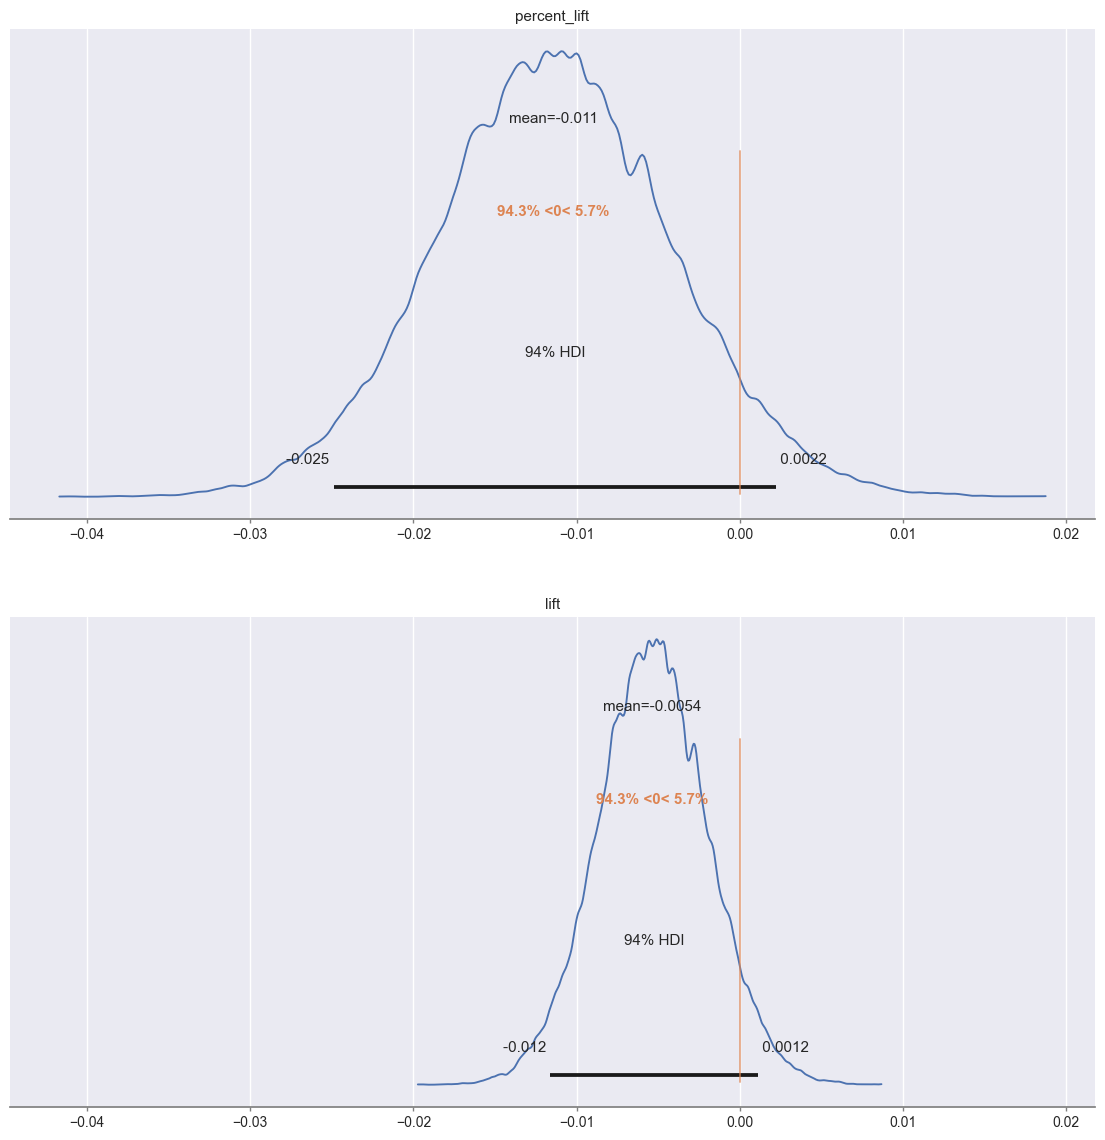

In [27]:
fig, axs = plt.subplots(2, 1, figsize=(14, 14), sharex=True)
az.plot_posterior(burned_trace, textsize=10, var_names = ["lift"], ax=axs[1], ref_val = 0)
az.plot_posterior(burned_trace, textsize=10, var_names = ["percent_lift"], ax=axs[0], ref_val = 0)

plt.show()

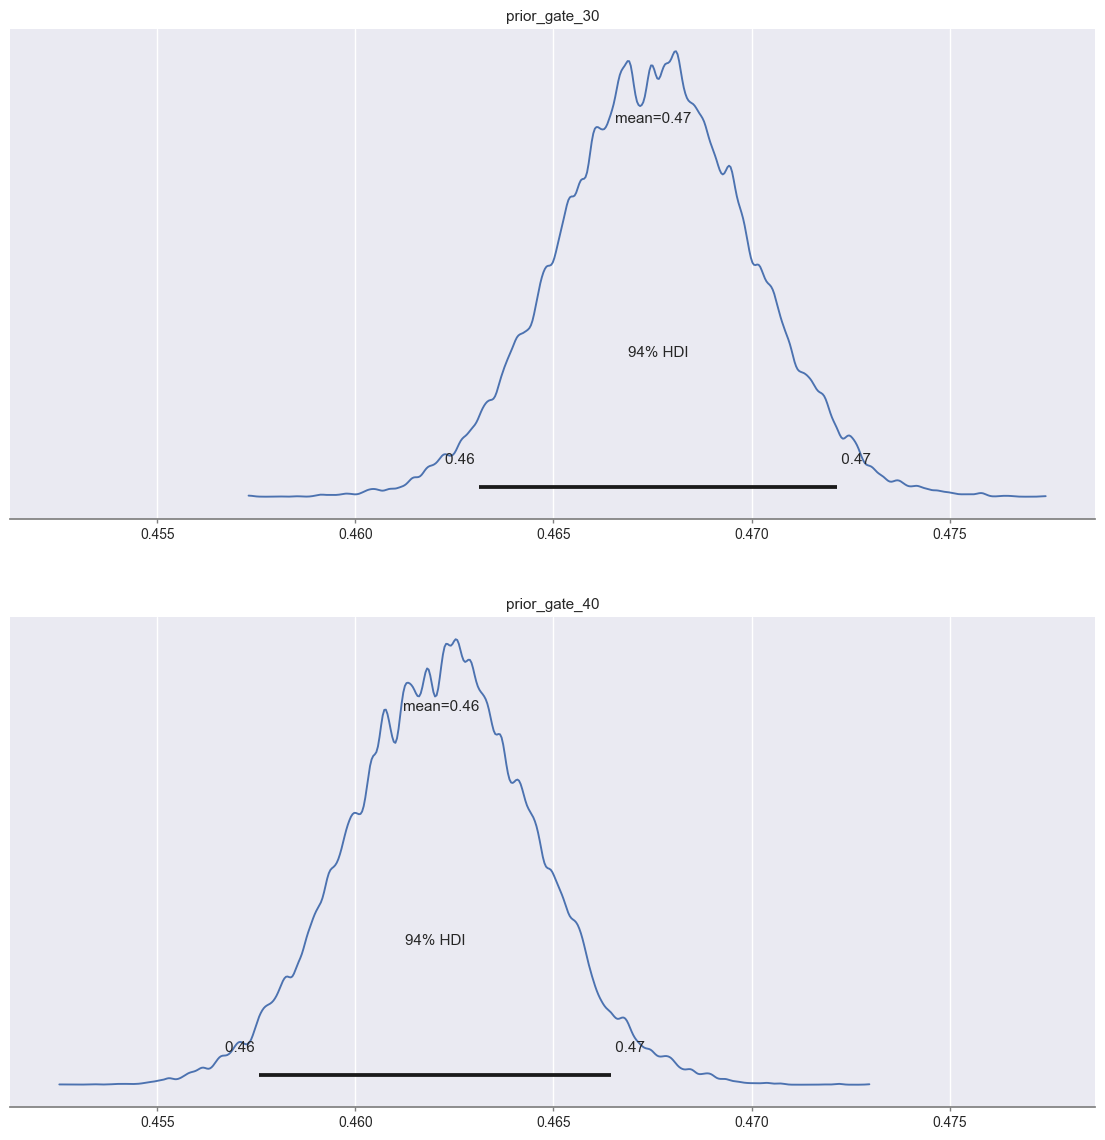

In [28]:
fig, axs = plt.subplots(2, 1, figsize=(14, 14), sharex=True)
az.plot_posterior(burned_trace, var_names = ["prior_gate_30"], textsize=10, ax=axs[0])
az.plot_posterior(burned_trace, var_names = ["prior_gate_40"], textsize=10, ax=axs[1])

plt.show()

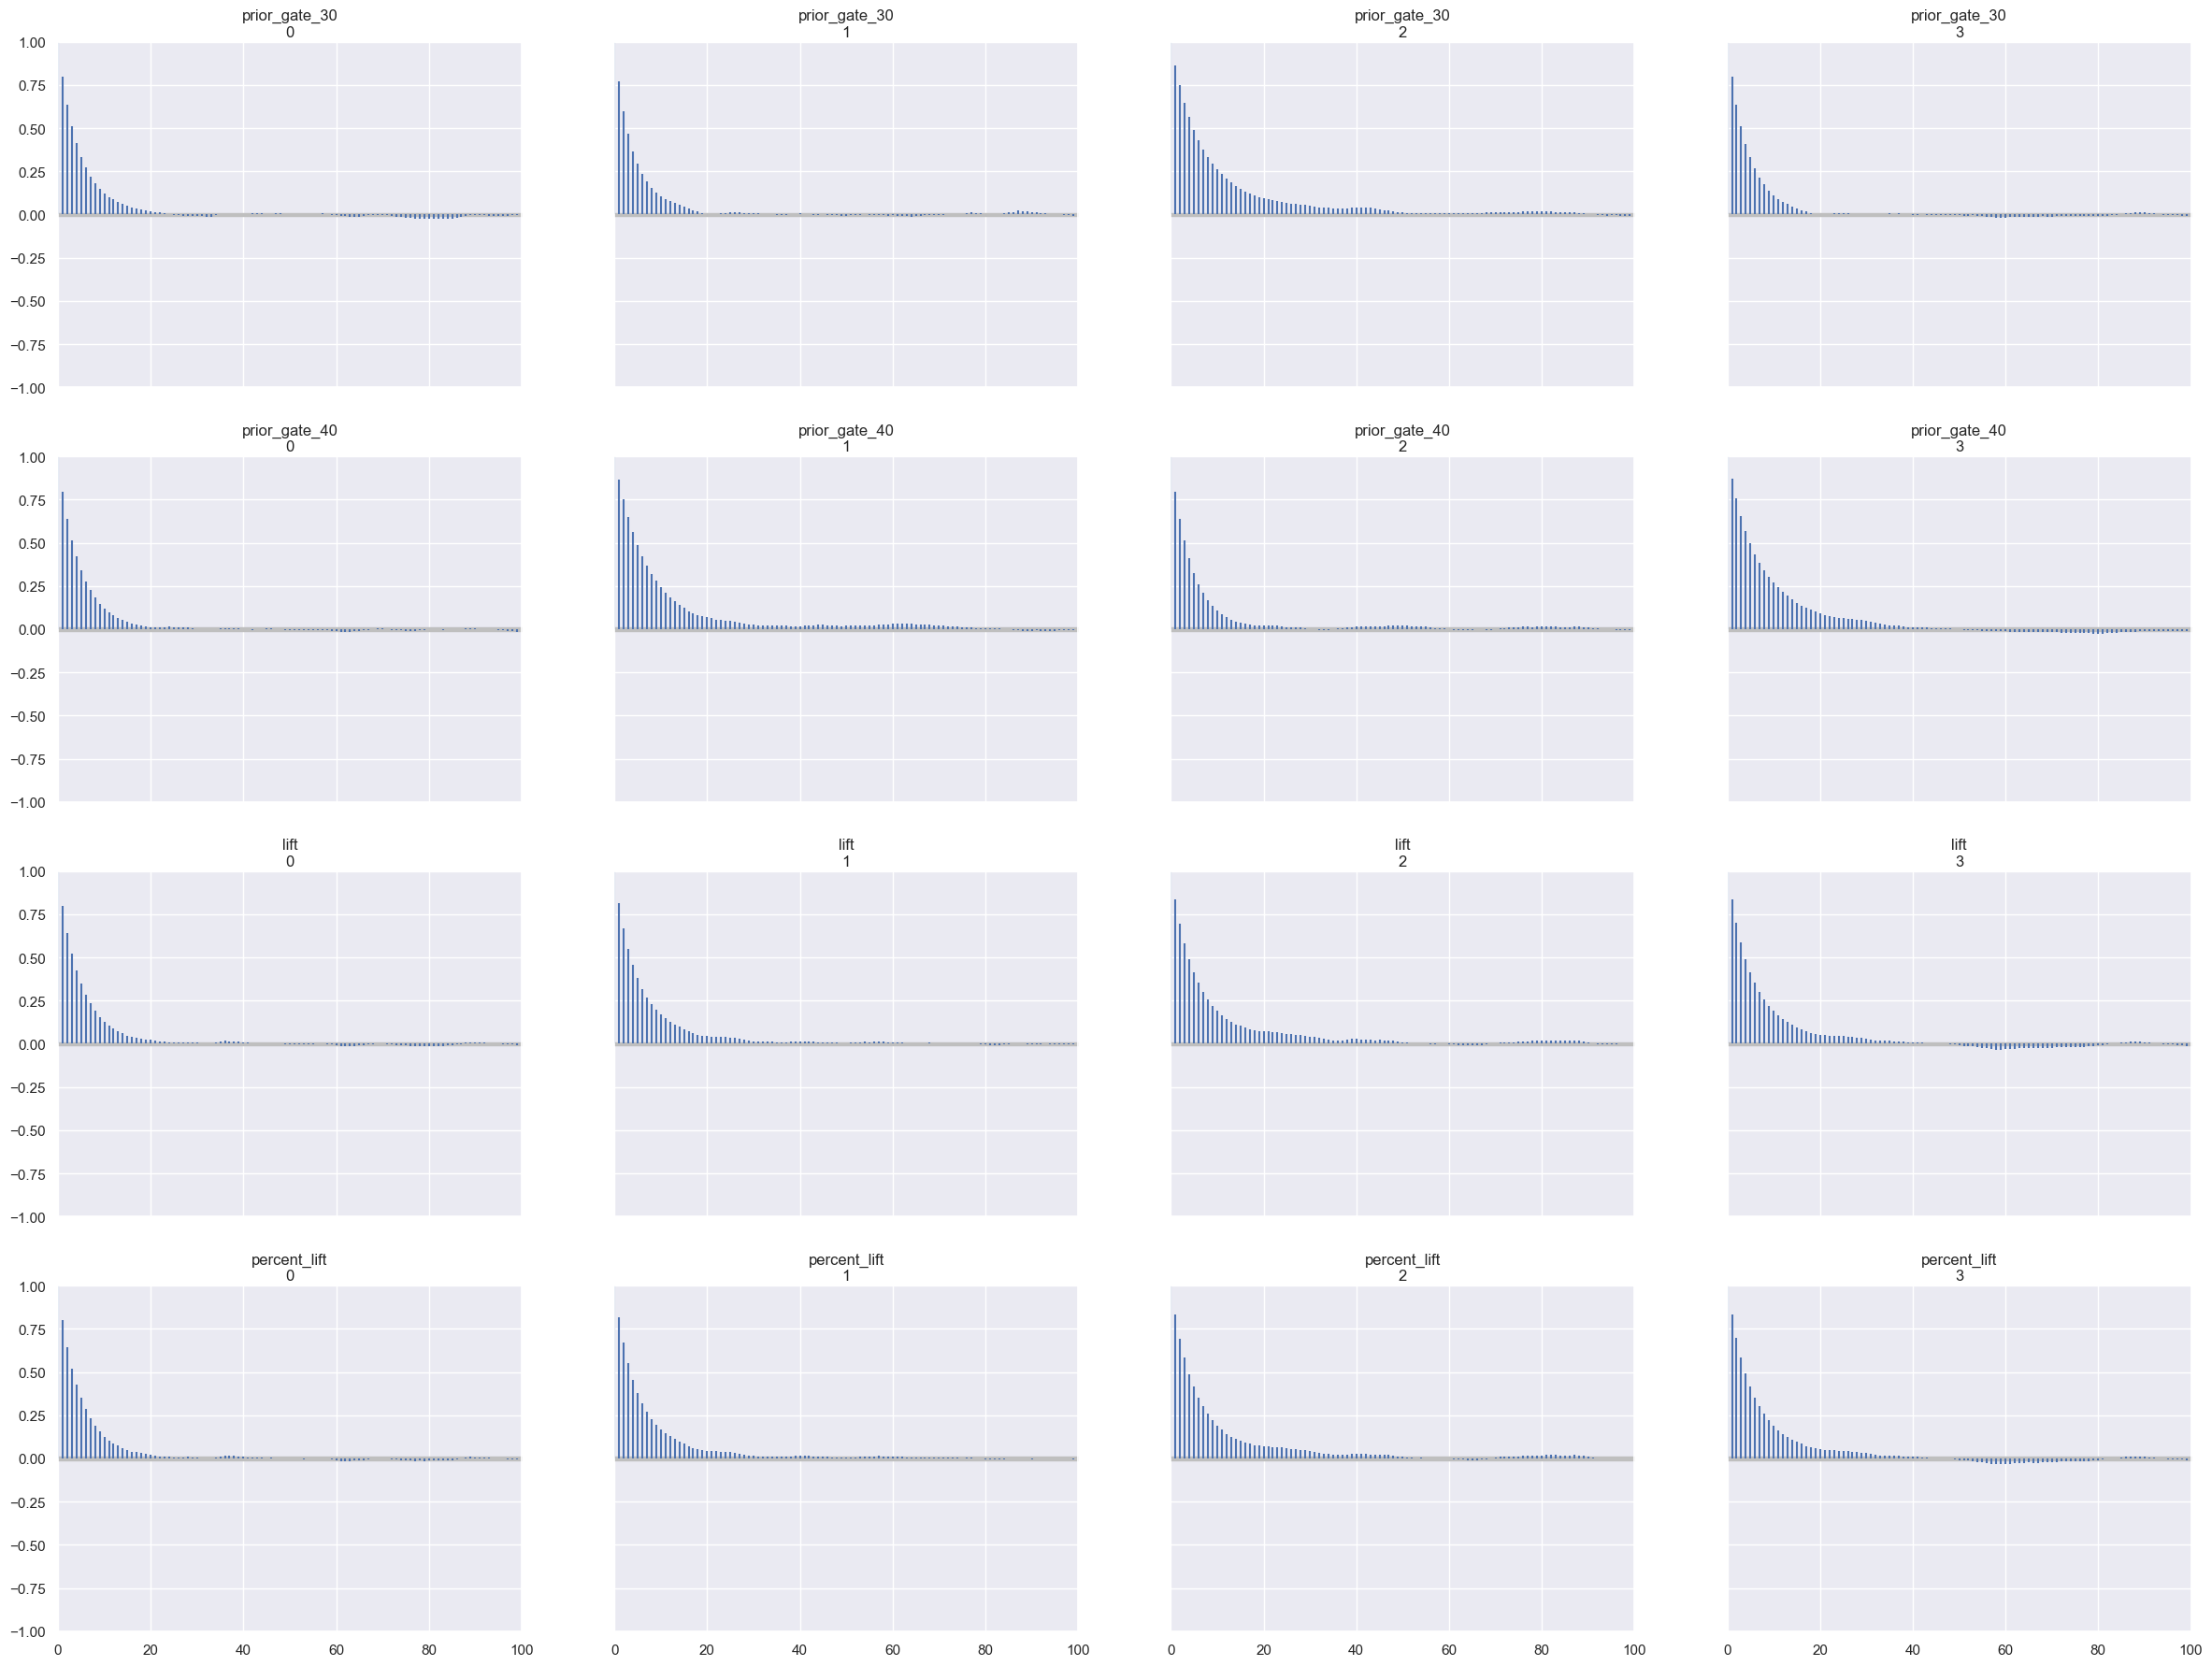

In [29]:
az.plot_autocorr(burned_trace)
plt.show()

In [28]:
az.summary(burned_trace, group = "posterior")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prior_gate_30,0.468,0.002,0.463,0.472,0.0,0.0,18880.0,20338.0,1.0
prior_gate_40,0.462,0.002,0.458,0.467,0.0,0.0,19621.0,20309.0,1.0
lift,-0.005,0.003,-0.012,0.001,0.0,0.0,18137.0,26212.0,1.0
percent_lift,-0.011,0.007,-0.025,0.002,0.0,0.0,18150.0,26266.0,1.0


### `retention_7`

In [29]:
with pm.Model() as retention_7:

    # prior
    prior_gate_30 = pm.Beta('prior_gate_30', alpha=1, beta=1)
    prior_gate_40 = pm.Beta('prior_gate_40', alpha=1, beta=1)

    # metrics
    pm.Deterministic('lift', prior_gate_40 - prior_gate_30)
    pm.Deterministic('percent_lift', (prior_gate_40/prior_gate_30) - 1)

    # likelihood 
    lik_gate_30 = pm.Binomial('lik_gate_30', n=len(df_gate_30), p=prior_gate_30, observed=sum(df_gate_30["retention_7"]))
    lik_gate_40 = pm.Binomial('lik_gate_40', n=len(df_gate_40), p=prior_gate_40, observed=sum(df_gate_40["retention_7"]))

    # Gibbs sampling step method
    step = pm.Metropolis(vars=[prior_gate_30, prior_gate_40], proposal_distribution=pm.Categorical)
    # trace
    trace = pm.sample(draws=50000, step = step, progressbar=True, chains = 4)
    burned_trace = trace.sel(draw=slice(10000, None))

Multiprocess sampling (4 chains in 2 jobs)
CompoundStep
>Metropolis: [prior_gate_30]
CompoundStep
>Metropolis: [prior_gate_30]
>Metropolis: [prior_gate_40]


<Figure size 700x700 with 0 Axes>

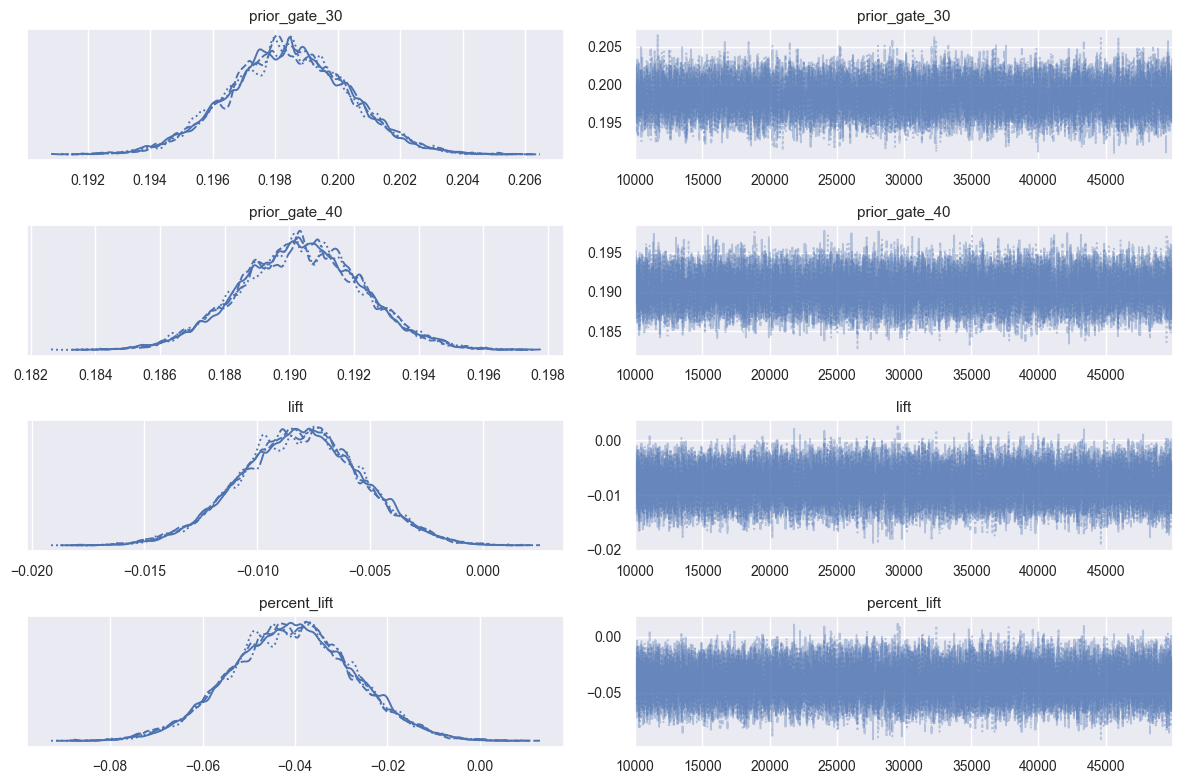

In [30]:
plt.figure(figsize=(7, 7))
az.plot_trace(burned_trace)
plt.tight_layout()

In [31]:
post_gate_30 = burned_trace["posterior"]["prior_gate_30"]
post_gate_40 = burned_trace["posterior"]["prior_gate_40"]
post_lift = burned_trace["posterior"]["lift"]
post_p_lift = burned_trace["posterior"]["percent_lift"]

/var/folders/1z/rcb05c357mq09gbkdvjb882c0000gn/T/ipykernel_13796/1221642630.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(post_gate_30[1].values, hist=True, kde=True, bins=25, label=r"$\pi(\theta_A^1|\underset{{\_}}{x}_A)$", color="tab:red", kde_kws={'linewidth': 2})
/var/folders/1z/rcb05c357mq09gbkdvjb882c0000gn/T/ipykernel_13796/1221642630.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the 

Text(-0.04047980568646202, 31.912848663876005, '$E[PL] = -0.04$')

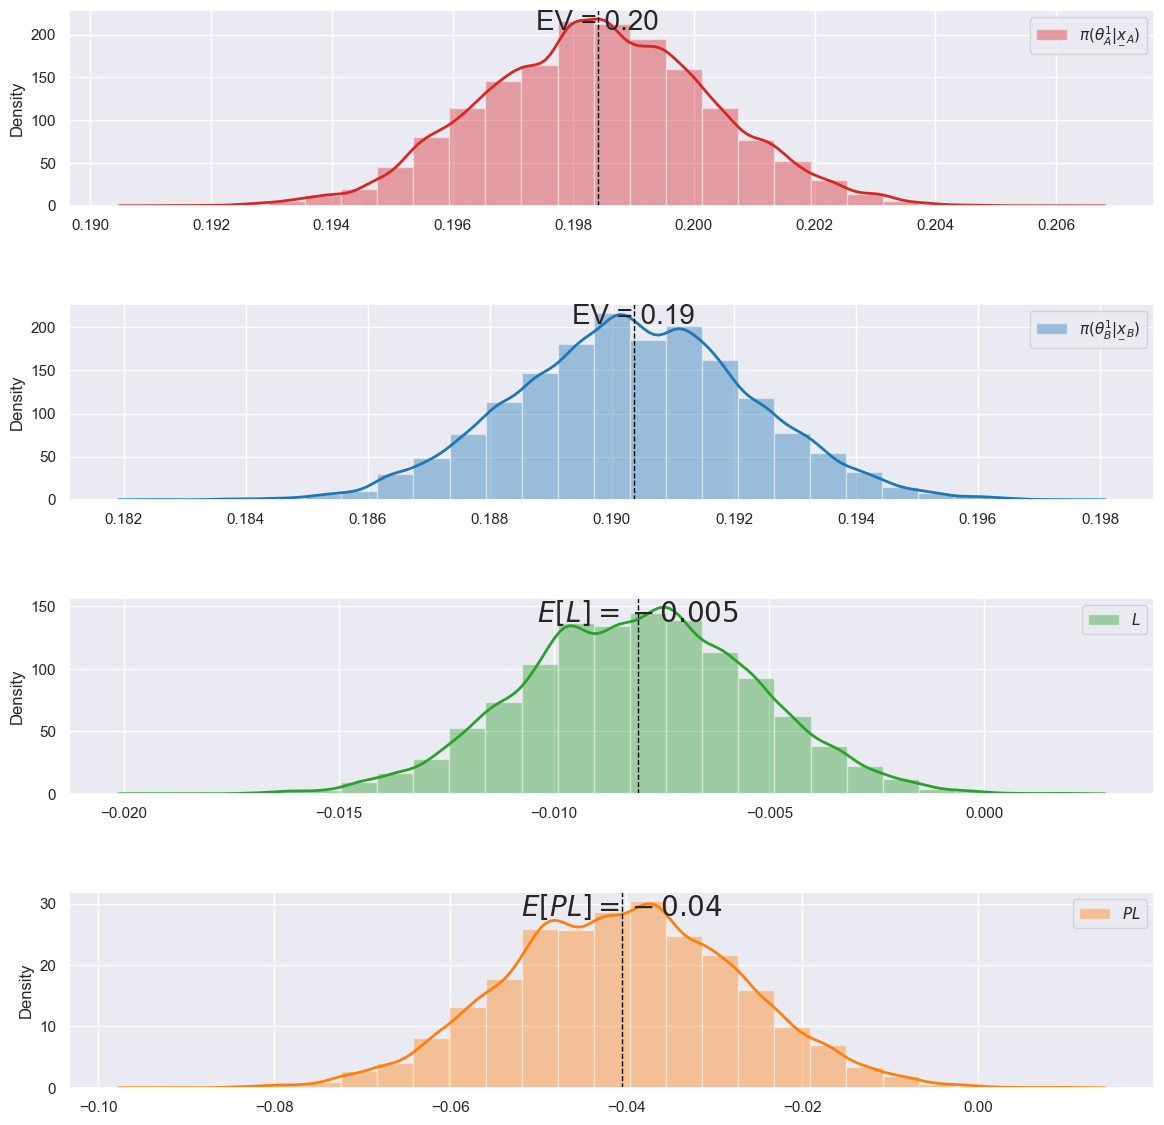

In [39]:
# create a new figure with a larger size
fig = plt.figure(figsize=(14, 14))
sns.set_theme()

# create subplots as before
ax = plt.subplot(411)
plt.subplots_adjust(hspace=0.5)
sns.distplot(post_gate_30[1].values, hist=True, kde=True, bins=25, label=r"$\pi(\theta_A^1|\underset{{\_}}{x}_A)$", color="tab:red", kde_kws={'linewidth': 2})
plt.legend(loc="upper right")

# calculate and add the expected value
mu_30 = np.mean(post_gate_30[1].values)
plt.axvline(mu_30, color='black', linestyle='dashed', linewidth=1)
plt.text(mu_30, plt.ylim()[1],f'EV = {mu_30:.2f}', ha='center', va='top', fontsize=20)

ax = plt.subplot(412)
sns.distplot(post_gate_40[1].values, hist=True, kde=True, bins=25, label=r"$\pi(\theta_B^1|\underset{{\_}}{x}_B)$", color="tab:blue", kde_kws={'linewidth': 2})
plt.legend(loc="upper right")
# calculate and add the expected value
mu_40 = np.mean(post_gate_40[1].values)
plt.axvline(mu_40, color='black', linestyle='dashed', linewidth=1)
plt.text(mu_40, plt.ylim()[1], f'EV = {mu_40:.2f}', ha='center', va='top', fontsize=20)

ax = plt.subplot(413)
sns.distplot(post_lift[1].values, hist=True, kde=True, bins=25, label="$L$", color="tab:green", kde_kws={'linewidth': 2})
plt.legend(loc="upper right")
# calculate and add the expected value
mu_lift = np.mean(post_lift[1].values)
plt.axvline(mu_lift, color='black', linestyle='dashed', linewidth=1)
plt.text(mu_lift, plt.ylim()[1], f'$E[L] = -0.005$', ha='center', va='top', fontsize=20)

ax = plt.subplot(414)
sns.distplot(post_p_lift[1].values, hist=True, kde=True, bins=25, label="$PL$", color="tab:orange", kde_kws={'linewidth': 2})
plt.legend(loc="upper right")
# calculate and add the expected value
mu_p_lift = np.mean(post_p_lift[1].values)
plt.axvline(mu_p_lift, color='black', linestyle='dashed', linewidth=1)
plt.text(mu_p_lift, plt.ylim()[1], f'$E[PL] = {mu_p_lift:.2f}$', ha='center', va='top', fontsize=20)

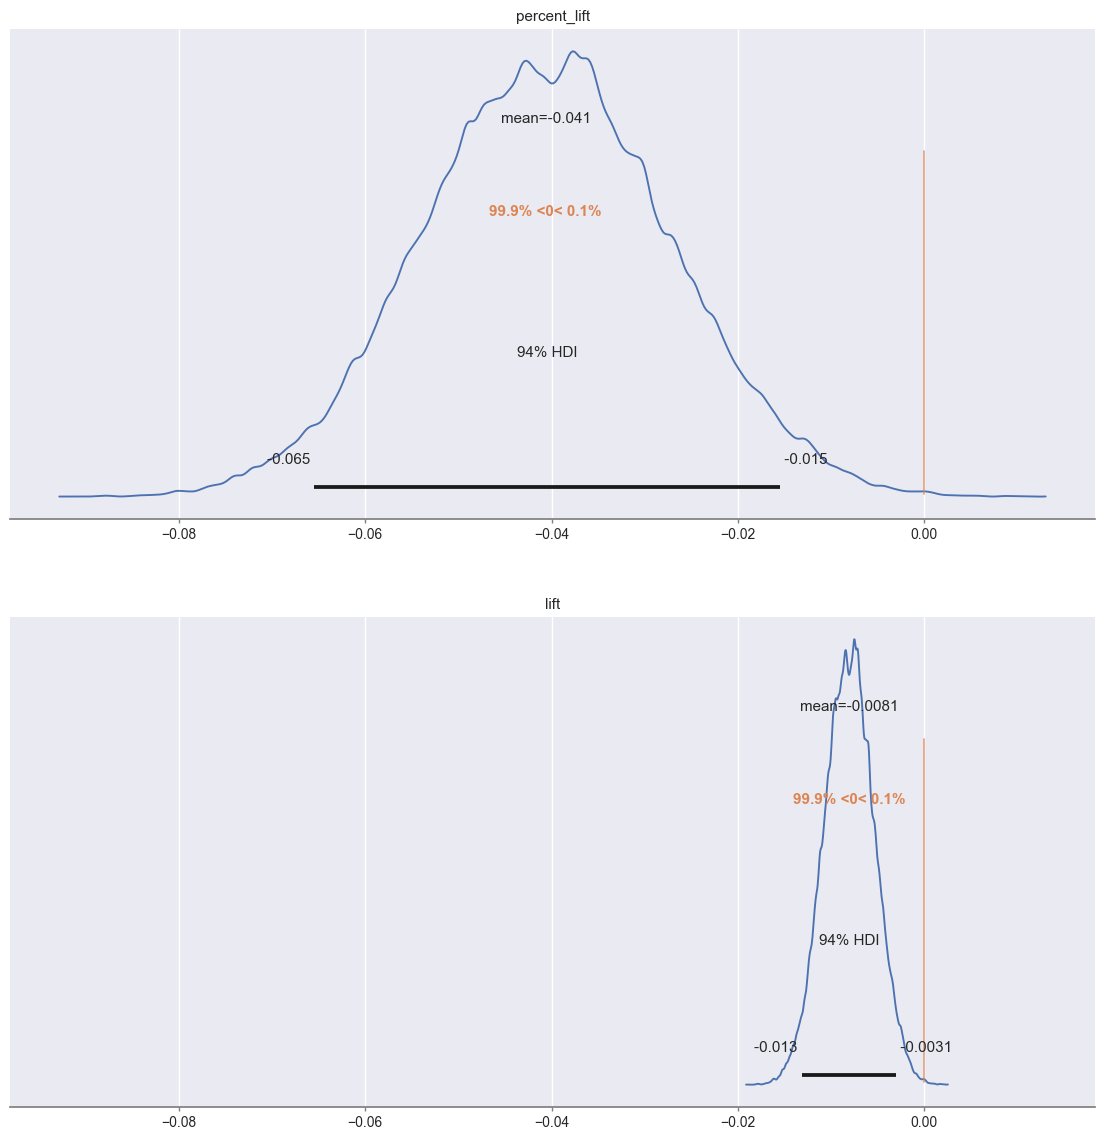

In [40]:
fig, axs = plt.subplots(2, 1, figsize=(14, 14), sharex=True)
az.plot_posterior(burned_trace, textsize=10, var_names = ["lift"], ax=axs[1], ref_val = 0)
az.plot_posterior(burned_trace, textsize=10, var_names = ["percent_lift"], ax=axs[0], ref_val = 0)

plt.show()

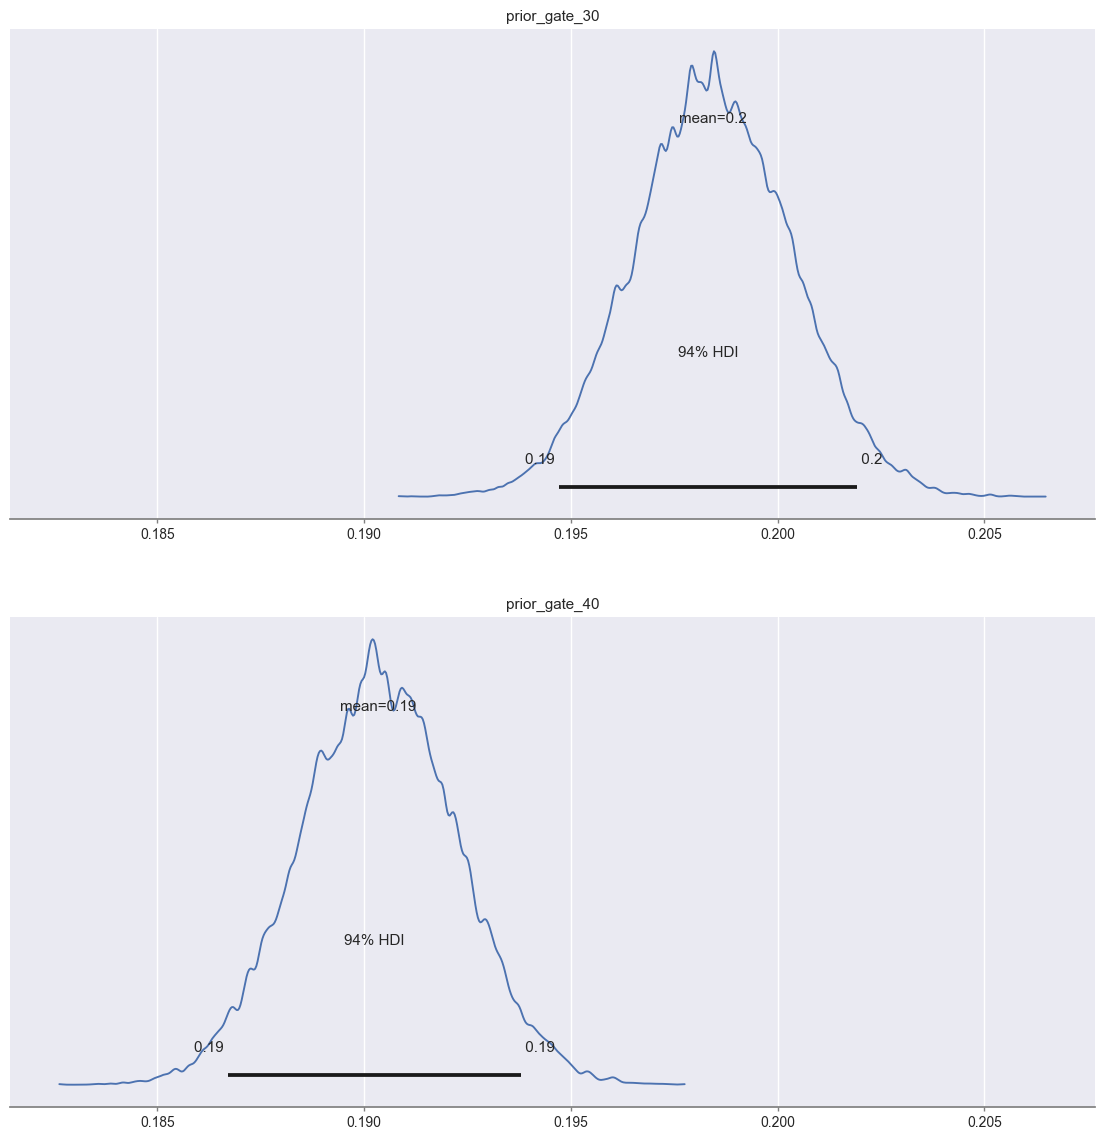

In [41]:
fig, axs = plt.subplots(2, 1, figsize=(14, 14), sharex=True)
az.plot_posterior(burned_trace, var_names = ["prior_gate_30"], textsize=10, ax=axs[0])
az.plot_posterior(burned_trace, var_names = ["prior_gate_40"], textsize=10, ax=axs[1])

plt.show()

In [ ]:
az.plot_autocorr(burned_trace)
plt.show()

In [43]:
az.summary(burned_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prior_gate_30,0.198,0.002,0.195,0.202,0.0,0.0,14838.0,15662.0,1.0
prior_gate_40,0.190,0.002,0.187,0.194,0.0,0.0,16671.0,16092.0,1.0
lift,-0.008,0.003,-0.013,-0.003,0.0,0.0,15559.0,21997.0,1.0
percent_lift,-0.041,0.013,-0.065,-0.015,0.0,0.0,15597.0,21928.0,1.0


# Bayesian Logistic Regression

In [51]:
with pm.Model() as logistic:
   
    prior_beta_0 = pm.Normal('beta_0', 0, sigma = 10)
    prior_beta_1 = pm.Normal('beta_1', 0, sigma = 10)

    p = pm.Deterministic('p', pm.math.sigmoid(prior_beta_0 + prior_beta_1 * log_df["sum_gamerounds"]))

In [ ]:
with logistic:
    
    posterior = pm.Bernoulli("posterior", p, observed=log_df['retention_7'])
    step = pm.Metropolis()
    trace = pm.sample(2500, step = step, chains = 3)

In [26]:
trace = az.from_netcdf("logistic.nc") 
burned_trace = trace.sel(draw=slice(500, None))

array([[<Axes: title={'center': 'beta_1'}>,
        <Axes: title={'center': 'beta_1'}>]], dtype=object)

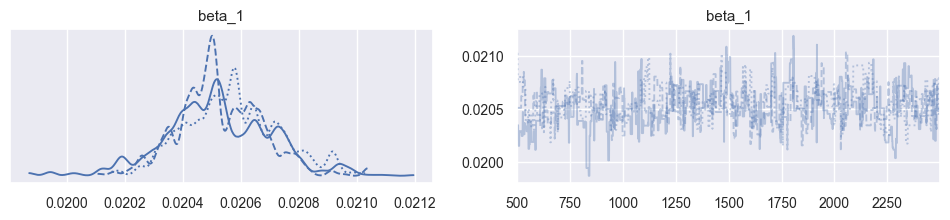

In [35]:
sns.set_theme()
az.plot_trace(burned_trace, var_names="beta_1")

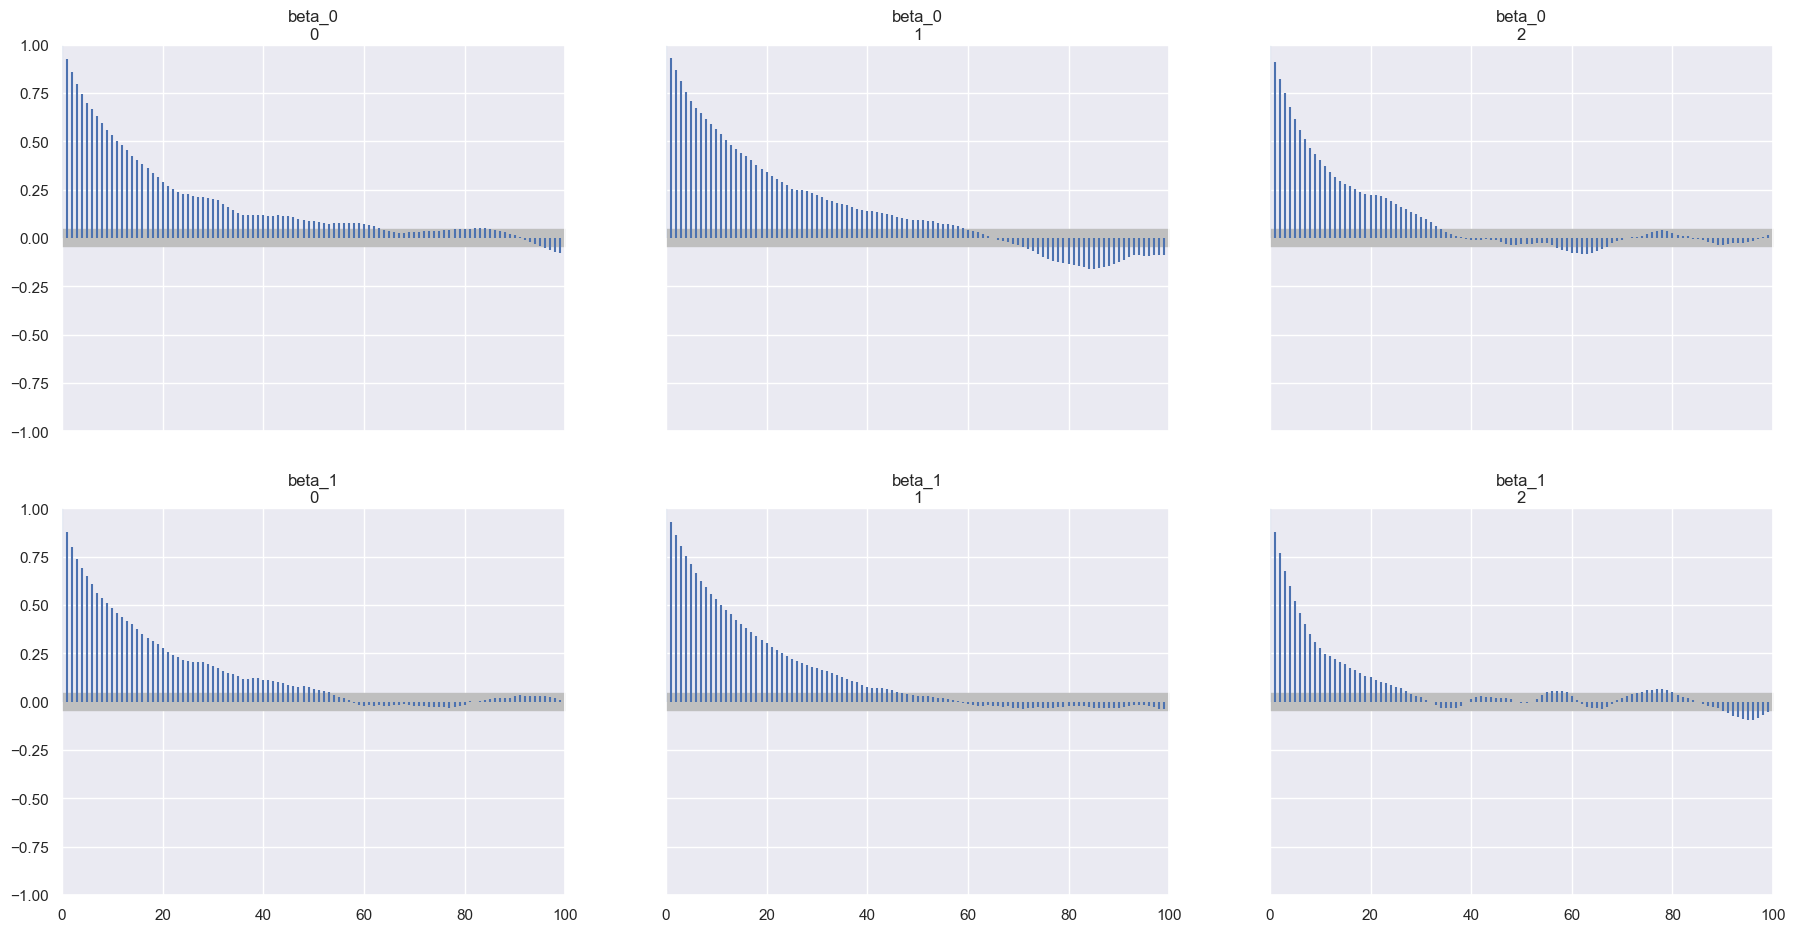

In [31]:
az.plot_autocorr(burned_trace, var_names=["beta_0", "beta_1"])
plt.show()

In [36]:
az.summary(burned_trace, var_names=["beta_0", "beta_1"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,-2.690,0.014,-2.719,-2.664,0.001,0.001,178.0,181.0,1.02
beta_1,0.021,0.000,0.020,0.021,0.000,0.000,205.0,236.0,1.02


In [32]:
post_beta_0 = burned_trace["posterior"]["beta_0"]
post_beta_1 = burned_trace["posterior"]["beta_1"]

/var/folders/1z/rcb05c357mq09gbkdvjb882c0000gn/T/ipykernel_7854/738925131.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(post_beta_0.values, hist=True, kde=True, bins=25, label=r"$\pi(\theta_A^1|\underset{{\_}}{x}_A)$", color="tab:red", kde_kws={'linewidth': 2})
/var/folders/1z/rcb05c357mq09gbkdvjb882c0000gn/T/ipykernel_7854/738925131.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new func

Text(0.020539122966135418, 2902.097485822206, 'EV = 0.02')

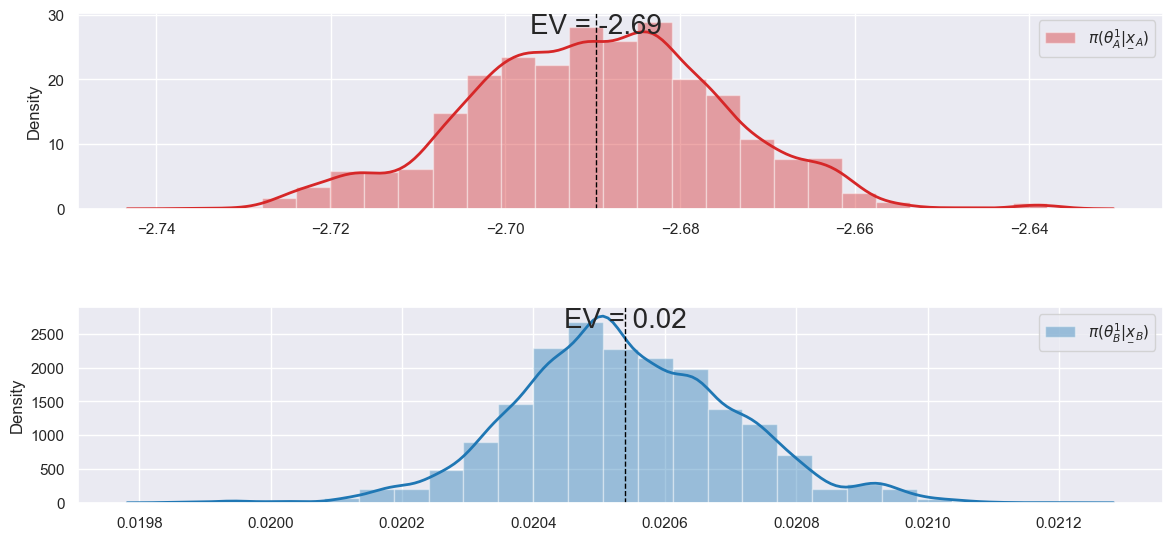

In [34]:
fig = plt.figure(figsize=(14, 14))
sns.set_theme()

# create subplots as before
ax = plt.subplot(411)
plt.subplots_adjust(hspace=0.5)
sns.distplot(post_beta_0.values, hist=True, kde=True, bins=25, label=r"$\pi(\theta_A^1|\underset{{\_}}{x}_A)$", color="tab:red", kde_kws={'linewidth': 2})
plt.legend(loc="upper right")

# calculate and add the expected value
mu_30 = np.mean(post_beta_0.values)
plt.axvline(mu_30, color='black', linestyle='dashed', linewidth=1)
plt.text(mu_30, plt.ylim()[1],f'EV = {mu_30:.2f}', ha='center', va='top', fontsize=20)

ax = plt.subplot(412)
sns.distplot(post_beta_1.values, hist=True, kde=True, bins=25, label=r"$\pi(\theta_B^1|\underset{{\_}}{x}_B)$", color="tab:blue", kde_kws={'linewidth': 2})
plt.legend(loc="upper right")
# calculate and add the expected value
mu_40 = np.mean(post_beta_1.values)
plt.axvline(mu_40, color='black', linestyle='dashed', linewidth=1)
plt.text(mu_40, plt.ylim()[1], f'EV = {mu_40:.2f}', ha='center', va='top', fontsize=20)